In [1]:
import os

In [2]:
# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/home/ra/Codes/multilang_timescale


In [3]:
import numpy 
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

from src.config import config_plotting

In [10]:
config_plotting()

In [4]:
# loading feature set

In [4]:
bert_feature_set = 'data/feature_set/timescales_BERT_all.npz'
mbert_feature_set = 'data/feature_set/timescales_mBERT_all.npz'

In [5]:
bert_features = numpy.load(bert_feature_set, allow_pickle=True)
bert_train_feature = bert_features['train'].tolist()

mbert_features = numpy.load(mbert_feature_set, allow_pickle=True)
mbert_train_feature = mbert_features['train'].tolist()

In [6]:
bert_train_feature_fast = bert_train_feature['2_4_words']
mbert_train_feature_fast = mbert_train_feature['2_4_words']

In [7]:
# compute cosine similarity between vectors adjecent in time
# for each sentence, compute the cosine similarity between the current and the next vector

lags = [1,2,4,8,16,32]

correlations = []

for lag in lags:
    bert_cosine_similarity = []

    for i in range(len(bert_train_feature_fast)):
        if i == len(bert_train_feature_fast)-lag:
            break
        else:
            bert_cosine_similarity.append(cosine_similarity(bert_train_feature_fast[i].reshape(1, -1), bert_train_feature_fast[i+lag].reshape(1, -1)))

    mbert_cosine_similarity = []

    for i in range(len(mbert_train_feature_fast)):
        if i == len(mbert_train_feature_fast)-lag:
            break
        else:
            mbert_cosine_similarity.append(cosine_similarity(mbert_train_feature_fast[i].reshape(1, -1), mbert_train_feature_fast[i+lag].reshape(1, -1)))

    bert_cosine_similarity = numpy.array(bert_cosine_similarity).ravel()
    mbert_cosine_similarity = numpy.array(mbert_cosine_similarity).ravel()

    # correlate cosine similarities
    corr = numpy.corrcoef(bert_cosine_similarity, mbert_cosine_similarity)[0, 1]

    correlations.append({
        'lag': lag,
        'correlation': corr,
        'bert_cosine_similarity': bert_cosine_similarity,
        'mbert_cosine_similarity': mbert_cosine_similarity})


In [9]:
correlations = pd.DataFrame(correlations)
correlations.head()

,lag,correlation,bert_cosine_similarity,mbert_cosine_similarity
0,1,0.969427,"[0.5687074678550835, 0.42524246383293235, 0.42...","[0.5189321243775824, 0.441329383008182, 0.5142..."
1,2,0.959196,"[-0.05338244682781634, 0.15512790122126258, 0....","[-0.07330028694983368, 0.2092013404158435, 0.1..."
2,4,0.940692,"[0.05715697656273283, 0.03441336251651576, -0....","[0.015341031483063046, 0.05454836687913138, -0..."
3,8,0.915525,"[-0.036519198482203544, 0.04253879087872895, -...","[-0.008087162309780684, 0.059243020893438234, ..."
4,16,0.912086,"[0.11107338446114082, 0.05957506759720007, 0.0...","[0.1100346470916932, 0.058305557133461014, -0...."


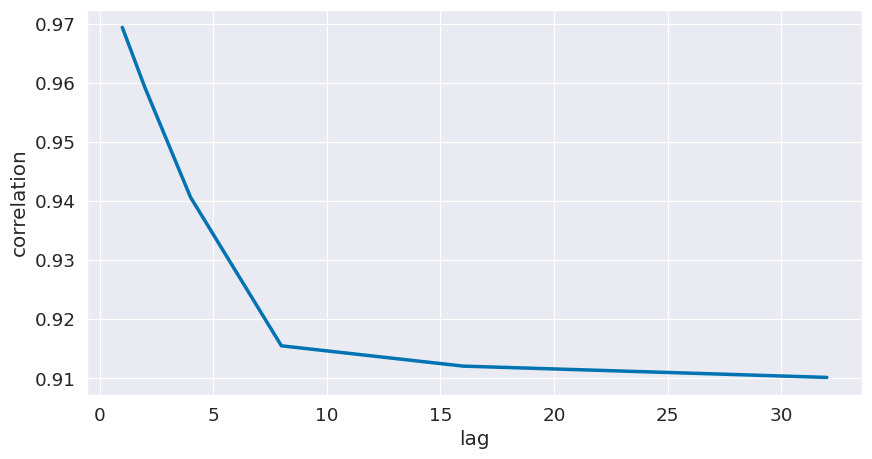

In [11]:
# plot bert vs mbert cosine similarity for different lags

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=correlations, x='lag', y='correlation', ax=ax)

ax.set_xlabel('lag')
ax.set_ylabel('correlation')

plt.show()

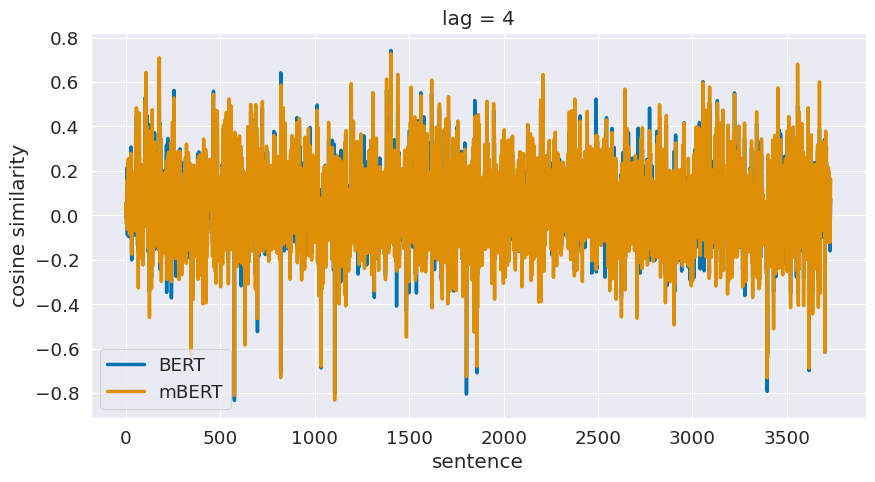

In [15]:
# plot lbert vs mbert cosine similarity time-serires of one of the lags
lag_idx = 2
max_len = 100

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(x=range(len(correlations['bert_cosine_similarity'][lag_idx])), y=correlations['bert_cosine_similarity'][lag_idx], ax=ax, label='BERT')
sns.lineplot(x=range(len(correlations['mbert_cosine_similarity'][lag_idx])), y=correlations['mbert_cosine_similarity'][lag_idx], ax=ax, label='mBERT')

ax.set_xlabel('sentence')
ax.set_ylabel('cosine similarity')

ax.set_title('lag = {}'.format(correlations['lag'][lag_idx]))

plt.show()

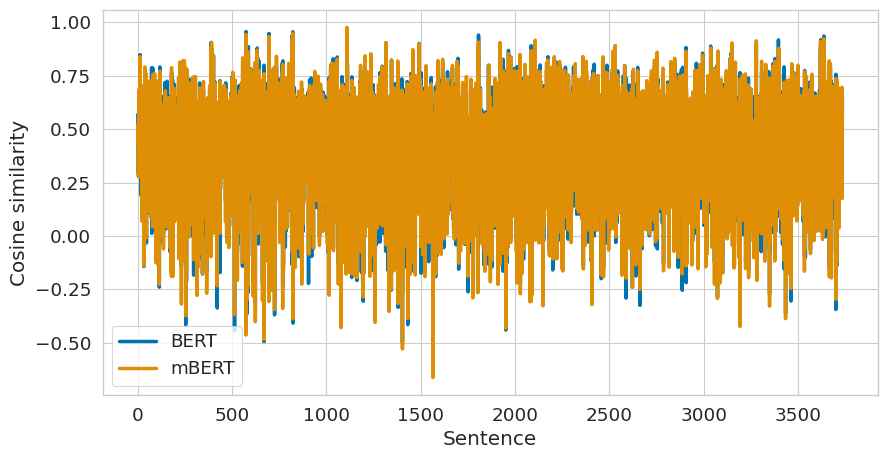

In [11]:
# plot line plot of cosine similarity of bert and mbert 

sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(correlations.iloc, label='BERT')
ax.plot(mbert_cosine_similarity, label='mBERT')

ax.set_xlabel('Sentence')
ax.set_ylabel('Cosine similarity')

ax.legend()

plt.show()